# Assignment 3: Language Models: Auto-Complete

In this assignment, you will build an auto-complete system.  Auto-complete system is something you may see every day
- When you google something, you often have suggestions to help you complete your search. 
- When you are writing an email, you get suggestions telling you possible endings to your sentence.  

By the end of this assignment, you will develop a prototype of such a system.

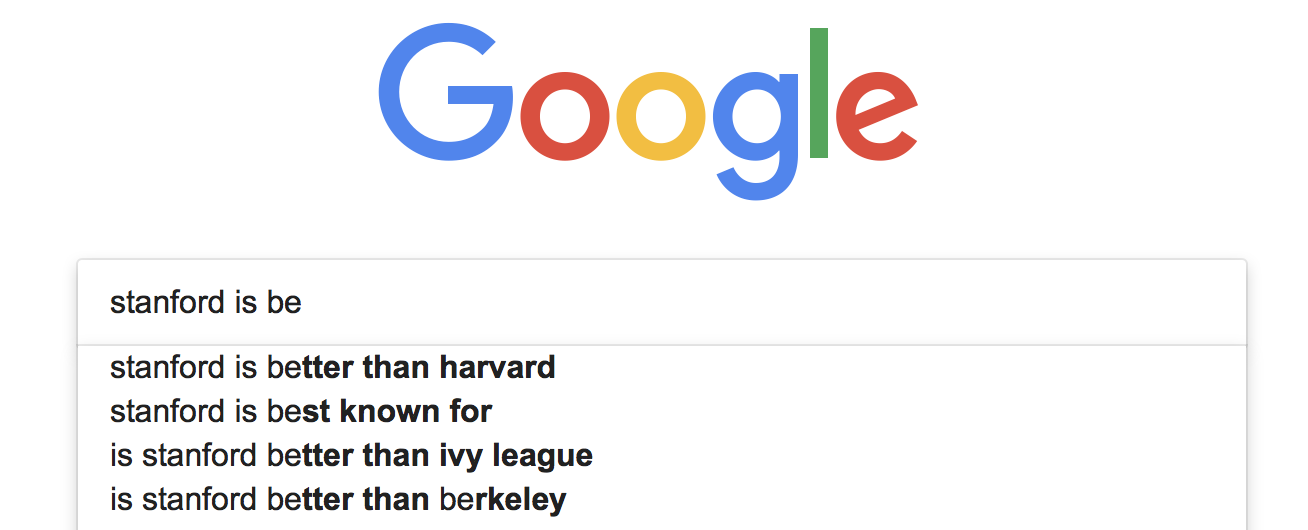

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/probabilistic-models-in-nlp/supplement/saGQf/how-to-refresh-your-workspace).

## Table of Contents
- [1 - Load and Preprocess Data](#1)
    - [1.1 - Load the Data](#1.1)
    - [1.2 - Pre-process the Data](#1.2)
        - [Exercise 1- split_to_sentences (UNQ_C1)](#ex-1)
        - [Exercise 2 - tokenize_sentences (UNQ_C2)](#ex-2)
        - [Exercise 3 - get_tokenized_data (UNQ_C3)](#ex-3)
        - [Exercise 4 - count_words (UNQ_C4)](#ex-4)
        - [Exercise 5 - get_words_with_nplus_frequency (UNQ_C5)](#ex-5)
        - [Exercise 6 - replace_oov_words_by_unk (UNQ_C6)](#ex-6)
        - [Exercise 7 - preprocess_data (UNQ_C7)](#ex-7)
- [2 - Develop n-gram based Language Models](#2)
    - [Exercise 8 - count_n_grams (UNQ_C8)](#ex-8)
    - [Exercise 9 - estimate_probability (UNQ_C9)](#ex-9)    
- [3 - Perplexity](#3)
    - [Exercise 10 - calculate_perplexity (UNQ_C10)](#ex-10)
- [4 - Build an Auto-complete System](#4)
    - [Exercise 11 - suggest_a_word (UNQ_C11)](#ex-11)

A key building block for an auto-complete system is a language model.
A language model assigns the probability to a sequence of words, in a way that more "likely" sequences receive higher scores.  For example, 
>"I have a pen" 
is expected to have a higher probability than 
>"I am a pen"
since the first one seems to be a more natural sentence in the real world.

You can take advantage of this probability calculation to develop an auto-complete system.  
Suppose the user typed 
>"I eat scrambled"
Then you can find a word `x`  such that "I eat scrambled x" receives the highest probability.  If x = "eggs", the sentence would be
>"I eat scrambled eggs"

While a variety of language models have been developed, this assignment uses **N-grams**, a simple but powerful method for language modeling.
- N-grams are also used in machine translation and speech recognition. 


Here are the steps of this assignment:

1. Load and preprocess data
    - Load and tokenize data.
    - Split the sentences into train and test sets.
    - Replace words with a low frequency by an unknown marker `<unk>`.
1. Develop N-gram based language models
    - Compute the count of n-grams from a given data set.
    - Estimate the conditional probability of a next word with k-smoothing.
1. Evaluate the N-gram models by computing the perplexity score.
1. Use your own model to suggest an upcoming word given your sentence. 

In [1]:
from google.colab import drive

# cd into directory in GDrive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/NLP/GitHub/C2_Probabilistic_Models/03_Autocomplete/

Mounted at /gdrive
/gdrive/MyDrive/NLP/GitHub/C2_Probabilistic_Models/03_Autocomplete


In [2]:
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

import w3_unittest
nltk.data.path.append('.')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<a name='1'></a>
## 1 - Load and Preprocess Data

<a name='1.1'></a>
### 1.1 - Load the Data
You will use twitter data.
Load the data and view the first few sentences by running the next cell.

Notice that data is a long string that contains many many tweets.
Observe that there is a line break "\n" between tweets.

In [3]:
with open("./data/en_US.twitter.txt", "r") as f:
    data = f.read()
print("Data type:", type(data))
print("Number of letters:", len(data))
print("First 300 letters of the data")
print("-------")
display(data[0:300])
print("-------")

print("Last 300 letters of the data")
print("-------")
display(data[-300:])
print("-------")

Data type: <class 'str'>
Number of letters: 3335477
First 300 letters of the data
-------


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A "

-------
Last 300 letters of the data
-------


"ust had one a few weeks back....hopefully we will be back soon! wish you the best yo\nColombia is with an 'o'...“: We now ship to 4 countries in South America (fist pump). Please welcome Columbia to the Stunner Family”\n#GutsiestMovesYouCanMake Giving a cat a bath.\nCoffee after 5 was a TERRIBLE idea.\n"

-------


<a name='1.2'></a>
### 1.2 - Pre-process the Data

Preprocess this data with the following steps:

1. Split data into sentences using "\n" as the delimiter.
1. Split each sentence into tokens. Note that in this assignment we use "token" and "words" interchangeably.
1. Assign sentences into train or test sets.
1. Find tokens that appear at least N times in the training data.
1. Replace tokens that appear less than N times by `<unk>`


Note: we omit validation data in this exercise.
- In real applications, we should hold a part of data as a validation set and use it to tune our training.
- We skip this process for simplicity.

<a name='ex-1'></a>
### Exercise 1- split_to_sentences

Split data into sentences.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Use <a href="https://docs.python.org/3/library/stdtypes.html?highlight=split#str.split" >str.split</a> </li>
</ul>
</p>

In [4]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C1 GRADED_FUNCTION: split_to_sentences ###
def split_to_sentences(data):
    """
    Split data by linebreak "\n"
    
    Args:
        data: str
    
    Returns:
        A list of sentences
    """
    ### START CODE HERE ###
    sentences = data.split('\n')
    ### END CODE HERE ###
    
    # Additional clearning (This part is already implemented)
    # - Remove leading and trailing spaces from each sentence
    # - Drop sentences if they are empty strings.
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]
    
    return sentences    

In [5]:
# test your code
x = """
I have a pen.\nI have an apple. \nAh\nApple pen.\n
"""
print(x)

split_to_sentences(x)


I have a pen.
I have an apple. 
Ah
Apple pen.




['I have a pen.', 'I have an apple.', 'Ah', 'Apple pen.']

Expected answer: 
```CPP
['I have a pen.', 'I have an apple.', 'Ah', 'Apple pen.']
```

In [6]:
# Test your function
w3_unittest.test_split_to_sentences(split_to_sentences)

 All tests passed


<a name='ex-2'></a>
### Exercise 2 - tokenize_sentences
The next step is to tokenize sentences (split a sentence into a list of words). 
- Convert all tokens into lower case so that words which are capitalized (for example, at the start of a sentence) in the original text are treated the same as the lowercase versions of the words.
- Append each tokenized list of words into a list of tokenized sentences.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use <a href="https://docs.python.org/3/library/stdtypes.html?highlight=split#str.lower" >str.lower</a> to convert strings to lowercase. </li>
    <li>Please use <a href="https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktLanguageVars.word_tokenize" >nltk.word_tokenize</a> to split sentences into tokens.</li>
    <li>If you used str.split instead of nltk.word_tokenize, there are additional edge cases to handle, such as the punctuation (comma, period) that follows a word.</li>
</ul>
</p>


In [12]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C2 GRADED_FUNCTION: tokenize_sentences ###
def tokenize_sentences(sentences):
    """
    Tokenize sentences into tokens (words)
    
    Args:
        sentences: List of strings
    
    Returns:
        List of lists of tokens
    """
    
    # Initialize the list of lists of tokenized sentences
    tokenized_sentences = []
    ### START CODE HERE ###
    
    # Go through each sentence
    for sentence in sentences: # complete this line
        
        # Convert to lowercase letters
        sentence = sentence.lower()
        
        # Convert into a list of words
        tokenized = nltk.word_tokenize(sentence)
        
        # append the list of words to the list of lists
        tokenized_sentences.append(tokenized)
    
    ### END CODE HERE ###
    
    return tokenized_sentences

In [13]:
# test your code
sentences = ["Sky is blue.", "Leaves are green.", "Roses are red."]
tokenize_sentences(sentences)

[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green', '.'],
 ['roses', 'are', 'red', '.']]

### Expected output

```CPP
[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green', '.'],
 ['roses', 'are', 'red', '.']]
```

In [14]:
# Test your function
w3_unittest.test_tokenize_sentences(tokenize_sentences)

 All tests passed


<a name='ex-3'></a>
### Exercise 3 - get_tokenized_data


Use the two functions that you have just implemented to get the tokenized data.
- split the data into sentences
- tokenize those sentences

In [57]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C3 GRADED_FUNCTION: get_tokenized_data ###
def get_tokenized_data(data):
    """
    Make a list of tokenized sentences
    
    Args:
        data: String
    
    Returns:
        List of lists of tokens
    """
    ### START CODE HERE ###
    
    # Get the sentences by splitting up the data
    sentences = data.strip().split("\n")
    
    # Get the list of lists of tokens by tokenizing the sentences
    tokenized_sentences = [nltk.word_tokenize(s.lower()) for s in sentences if s.strip()]
    
    ### END CODE HERE ###
    
    return tokenized_sentences

In [58]:
# test your function
x = "Sky is blue.\nLeaves are green\nRoses are red."
get_tokenized_data(x)

[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green'],
 ['roses', 'are', 'red', '.']]

##### Expected outcome

```CPP
[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green'],
 ['roses', 'are', 'red', '.']]
```

In [59]:
# Test your function
w3_unittest.test_get_tokenized_data(get_tokenized_data)

 All tests passed


#### Split into train and test sets

Now run the cell below to split data into training and test sets.

In [60]:
tokenized_data = get_tokenized_data(data)
random.seed(87)
random.shuffle(tokenized_data)

train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [61]:
print("{} data are split into {} train and {} test set".format(
    len(tokenized_data), len(train_data), len(test_data)))

print("First training sample:")
print(train_data[0])
      
print("First test sample")
print(test_data[0])

47961 data are split into 38368 train and 9593 test set
First training sample:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the', 'team', 'local', 'company', 'and', 'quality', 'production']
First test sample
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']


##### Expected output

```CPP
47961 data are split into 38368 train and 9593 test set
First training sample:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the', 'team', 'local', 'company', 'and', 'quality', 'production']
First test sample
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']
```

<a name='ex-4'></a>
### Exercise 4 - count_words

You won't use all the tokens (words) appearing in the data for training.  Instead, you will use the more frequently used words.  
- You will focus on the words that appear at least N times in the data.
- First count how many times each word appears in the data.

You will need a double for-loop, one for sentences and the other for tokens within a sentence.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>If you decide to import and use defaultdict, remember to cast the dictionary back to a regular 'dict' before returning it. </li>
</ul>
</p>


In [62]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C4 GRADED_FUNCTION: count_words ###
def count_words(tokenized_sentences):
    """
    Count the number of word appearence in the tokenized sentences
    
    Args:
        tokenized_sentences: List of lists of strings
    
    Returns:
        dict that maps word (str) to the frequency (int)
    """
            
    word_counts = {}
    ### START CODE HERE ###
    
    # Loop through each sentence
    for sentence in tokenized_sentences: # complete this line
        
        # Go through each token in the sentence
        for token in sentence: # complete this line

            # If the token is not in the dictionary yet, set the count to 1
            if token not in word_counts.keys(): # complete this line with the proper condition
                word_counts[token] = 1
            
            # If the token is already in the dictionary, increment the count by 1
            else:
                word_counts[token] += 1

    ### END CODE HERE ###
    
    return word_counts

In [63]:
# test your code
tokenized_sentences = [['sky', 'is', 'blue', '.'],
                       ['leaves', 'are', 'green', '.'],
                       ['roses', 'are', 'red', '.']]
count_words(tokenized_sentences)

{'sky': 1,
 'is': 1,
 'blue': 1,
 '.': 3,
 'leaves': 1,
 'are': 2,
 'green': 1,
 'roses': 1,
 'red': 1}

##### Expected output

Note that the order may differ.

```CPP
{'sky': 1,
 'is': 1,
 'blue': 1,
 '.': 3,
 'leaves': 1,
 'are': 2,
 'green': 1,
 'roses': 1,
 'red': 1}
```

In [64]:
# Test your function
w3_unittest.test_count_words(count_words)

 All tests passed


#### Handling 'Out of Vocabulary' words

If your model is performing autocomplete, but encounters a word that it never saw during training, it won't have an input word to help it determine the next word to suggest. The model will not be able to predict the next word because there are no counts for the current word. 
- This 'new' word is called an 'unknown word', or <b>out of vocabulary (OOV)</b> words.
- The percentage of unknown words in the test set is called the <b> OOV </b> rate. 

To handle unknown words during prediction, use a special token to represent all unknown words 'unk'. 
- Modify the training data so that it has some 'unknown' words to train on.
- Words to convert into "unknown" words are those that do not occur very frequently in the training set.
- Create a list of the most frequent words in the training set, called the <b> closed vocabulary </b>. 
- Convert all the other words that are not part of the closed vocabulary to the token 'unk'. 




<a name='ex-5'></a>
### Exercise 5 - get_words_with_nplus_frequency

You will now create a function that takes in a text document and a threshold `count_threshold`.
- Any word whose count is greater than or equal to the threshold `count_threshold` is kept in the closed vocabulary.
- Returns the word closed vocabulary list. 

In [67]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C5 GRADED_FUNCTION: get_words_with_nplus_frequency ###
def get_words_with_nplus_frequency(tokenized_sentences, count_threshold):
    """
    Find the words that appear N times or more
    
    Args:
        tokenized_sentences: List of lists of sentences
        count_threshold: minimum number of occurrences for a word to be in the closed vocabulary.
    
    Returns:
        List of words that appear N times or more
    """
    # Initialize an empty list to contain the words that
    # appear at least 'minimum_freq' times.
    closed_vocab = []
    
    # Get the word couts of the tokenized sentences
    # Use the function that you defined earlier to count the words
    word_counts = count_words(tokenized_sentences)
    
    ### START CODE HERE ###
#   UNIT TEST COMMENT: Whole thing can be one-lined with list comprehension
#   filtered_words = None

    # for each word and its count
    for word, cnt in word_counts.items(): # complete this line
        
        # check that the word's count
        # is at least as great as the minimum count
        if cnt >= count_threshold: # complete this line with the proper condition
            
            # append the word to the list
            closed_vocab.append(word)
    ### END CODE HERE ###
    
    return closed_vocab

In [68]:
# test your code
tokenized_sentences = [['sky', 'is', 'blue', '.'],
                       ['leaves', 'are', 'green', '.'],
                       ['roses', 'are', 'red', '.']]
tmp_closed_vocab = get_words_with_nplus_frequency(tokenized_sentences, count_threshold=2)
print(f"Closed vocabulary:")
print(tmp_closed_vocab)

Closed vocabulary:
['.', 'are']


##### Expected output

```CPP
Closed vocabulary:
['.', 'are']
```

In [69]:
# Test your function
w3_unittest.test_get_words_with_nplus_frequency(get_words_with_nplus_frequency)

 All tests passed


<a name='ex-6'></a>
### Exercise 6 - replace_oov_words_by_unk

The words that appear `count_threshold` times or more are in the closed vocabulary. 
- All other words are regarded as `unknown`.
- Replace words not in the closed vocabulary with the token `<unk>`.

In [70]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C6 GRADED_FUNCTION: replace_oov_words_by_unk ###
def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
    """
    Replace words not in the given vocabulary with '<unk>' token.
    
    Args:
        tokenized_sentences: List of lists of strings
        vocabulary: List of strings that we will use
        unknown_token: A string representing unknown (out-of-vocabulary) words
    
    Returns:
        List of lists of strings, with words not in the vocabulary replaced
    """
    
    # Place vocabulary into a set for faster search
    vocabulary = set(vocabulary)
    
    # Initialize a list that will hold the sentences
    # after less frequent words are replaced by the unknown token
    replaced_tokenized_sentences = []
    
    # Go through each sentence
    for sentence in tokenized_sentences:
        
        # Initialize the list that will contain
        # a single sentence with "unknown_token" replacements
        replaced_sentence = []
        ### START CODE HERE (Replace instances of 'None' with your code) ###

        # for each token in the sentence
        for token in sentence: # complete this line
            
            # Check if the token is in the closed vocabulary
            if token in vocabulary: # complete this line with the proper condition
                # If so, append the word to the replaced_sentence
                replaced_sentence.append(token)
            else:
                # otherwise, append the unknown token instead
                replaced_sentence.append(unknown_token)
        ### END CODE HERE ###
        
        # Append the list of tokens to the list of lists
        replaced_tokenized_sentences.append(replaced_sentence)
    return replaced_tokenized_sentences

In [71]:
tokenized_sentences = [["dogs", "run"], ["cats", "sleep"]]
vocabulary = ["dogs", "sleep"]
tmp_replaced_tokenized_sentences = replace_oov_words_by_unk(tokenized_sentences, vocabulary)
print(f"Original sentence:")
print(tokenized_sentences)
print(f"tokenized_sentences with less frequent words converted to '<unk>':")
print(tmp_replaced_tokenized_sentences)

Original sentence:
[['dogs', 'run'], ['cats', 'sleep']]
tokenized_sentences with less frequent words converted to '<unk>':
[['dogs', '<unk>'], ['<unk>', 'sleep']]


### Expected answer

```CPP
Original sentence:
[['dogs', 'run'], ['cats', 'sleep']]
tokenized_sentences with less frequent words converted to '<unk>':
[['dogs', '<unk>'], ['<unk>', 'sleep']]
```

In [72]:
# Test your function
w3_unittest.test_replace_oov_words_by_unk(replace_oov_words_by_unk)

 All tests passed


<a name='ex-7'></a>
### Exercise 7 - preprocess_data

Now we are ready to process our data by combining the functions that you just implemented.

1. Find tokens that appear at least count_threshold times in the training data.
1. Replace tokens that appear less than count_threshold times by "<unk\>" both for training and test data.

In [78]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C7 GRADED_FUNCTION: preprocess_data ###
def preprocess_data(train_data, test_data, count_threshold, unknown_token="<unk>", get_words_with_nplus_frequency=get_words_with_nplus_frequency, replace_oov_words_by_unk=replace_oov_words_by_unk):
    """
    Preprocess data, i.e.,
        - Find tokens that appear at least N times in the training data.
        - Replace tokens that appear less than N times by "<unk>" both for training and test data.        
    Args:
        train_data, test_data: List of lists of strings.
        count_threshold: Words whose count is less than this are 
                      treated as unknown.
    
    Returns:
        Tuple of
        - training data with low frequent words replaced by "<unk>"
        - test data with low frequent words replaced by "<unk>"
        - vocabulary of words that appear n times or more in the training data
    """
    ### START CODE HERE ###

    # Get the closed vocabulary using the train data
    vocabulary = get_words_with_nplus_frequency(train_data, count_threshold)
    
    # For the train data, replace less common words with "<unk>"
    train_data_replaced = replace_oov_words_by_unk(train_data, vocabulary, unknown_token)
    
    # For the test data, replace less common words with "<unk>"
    test_data_replaced = replace_oov_words_by_unk(test_data, vocabulary, unknown_token)
    
    ### END CODE HERE ###
    return train_data_replaced, test_data_replaced, vocabulary

In [79]:
# test your code
tmp_train = [['sky', 'is', 'blue', '.'],
     ['leaves', 'are', 'green']]
tmp_test = [['roses', 'are', 'red', '.']]

tmp_train_repl, tmp_test_repl, tmp_vocab = preprocess_data(tmp_train, 
                                                           tmp_test, 
                                                           count_threshold = 1
                                                          )

print("tmp_train_repl")
print(tmp_train_repl)
print()
print("tmp_test_repl")
print(tmp_test_repl)
print()
print("tmp_vocab")
print(tmp_vocab)

tmp_train_repl
[['sky', 'is', 'blue', '.'], ['leaves', 'are', 'green']]

tmp_test_repl
[['<unk>', 'are', '<unk>', '.']]

tmp_vocab
['sky', 'is', 'blue', '.', 'leaves', 'are', 'green']


##### Expected outcome

```CPP
tmp_train_repl
[['sky', 'is', 'blue', '.'], ['leaves', 'are', 'green']]

tmp_test_repl
[['<unk>', 'are', '<unk>', '.']]

tmp_vocab
['sky', 'is', 'blue', '.', 'leaves', 'are', 'green']
```

In [80]:
# Test your function
w3_unittest.test_preprocess_data(preprocess_data)

 All tests passed


#### Preprocess the train and test data
Run the cell below to complete the preprocessing both for training and test sets.

In [81]:
minimum_freq = 2
train_data_processed, test_data_processed, vocabulary = preprocess_data(train_data, 
                                                                        test_data, 
                                                                        minimum_freq)

In [82]:
print("First preprocessed training sample:")
print(train_data_processed[0])
print()
print("First preprocessed test sample:")
print(test_data_processed[0])
print()
print("First 10 vocabulary:")
print(vocabulary[0:10])
print()
print("Size of vocabulary:", len(vocabulary))

First preprocessed training sample:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the', 'team', 'local', 'company', 'and', 'quality', 'production']

First preprocessed test sample:
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']

First 10 vocabulary:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the']

Size of vocabulary: 14824


##### Expected output

```CPP
First preprocessed training sample:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the', 'team', 'local', 'company', 'and', 'quality', 'production']

First preprocessed test sample:
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']

First 10 vocabulary:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the']

Size of vocabulary: 14821
```

You are done with the preprocessing section of the assignment.
Objects `train_data_processed`, `test_data_processed`, and `vocabulary` will be used in the rest of the exercises.

<a name='2'></a>
## 2 - Develop n-gram based Language Models

In this section, you will develop the n-grams language model.
- Assume the probability of the next word depends only on the previous n-gram.
- The previous n-gram is the series of the previous 'n' words.

The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-n}\cdots w_{t-2}, w_{t-1}$ is:

$$ P(w_t | w_{t-n}\dots w_{t-1} ) \tag{1}$$

You can estimate this probability  by counting the occurrences of these series of words in the training data.
- The probability can be estimated as a ratio, where
- The numerator is the number of times word 't' appears after words t-n through t-1 appear in the training data.
- The denominator is the number of times word t-n through t-1 appears in the training data.


$$ \hat{P}(w_t | w_{t-n} \dots w_{t-1}) = \frac{C(w_{t-n}\dots w_{t-1}, w_t)}{C(w_{t-n}\dots w_{t-1})} \tag{2} $$


- The function $C(\cdots)$ denotes the number of occurence of the given sequence. 
- $\hat{P}$ means the estimation of $P$. 
- Notice that denominator of the equation (2) is the number of occurence of the previous $n$ words, and the numerator is the same sequence followed by the word $w_t$.

Later, you will modify the equation (2) by adding k-smoothing, which avoids errors when any counts are zero.

The equation (2) tells us that to estimate probabilities based on n-grams, you need the counts of n-grams (for denominator) and (n+1)-grams (for numerator).

<a name='ex-8'></a>
### Exercise 8 - count_n_grams
Next, you will implement a function that computes the counts of n-grams for an arbitrary number $n$.

When computing the counts for n-grams, prepare the sentence beforehand by prepending $n-1$ starting markers "<s\>" to indicate the beginning of the sentence.  
- For example, in the tri-gram model (n=3), a sequence with two start tokens "<s\>" should predict the first word of a sentence.
- So, if the sentence is "I like food", modify it to be "<s\> <s\> I like food".
- Also prepare the sentence for counting by appending an end token "<e\>" so that the model can predict when to finish a sentence.

Technical note: In this implementation, you will store the counts as a dictionary.
- The key of each key-value pair in the dictionary is a **tuple** of n words (and not a list)
- The value in the key-value pair is the number of occurrences.  
- The reason for using a tuple as a key instead of a list is because a list in Python is a mutable object (it can be changed after it is first created).  A tuple is "immutable", so it cannot be altered after it is first created.  This makes a tuple suitable as a data type for the key in a dictionary.
- Although for a n-gram you need to use n-1 starting markers for a sentence, you will want to prepend n starting markers in order to use them to compute the initial probability for the (n+1)-gram later in the assignment.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> To prepend or append, you can create lists and concatenate them using the + operator </li>
    <li> To create a list of a repeated value, you can follow this syntax: <code>['a'] * 3</code> to get <code>['a','a','a']</code> </li>
    <li>To set the range for index 'i', think of this example: An n-gram where n=2 (bigram), and the sentence is length N=5 (including one start token and one end token).  So the index positions are <code>[0,1,2,3,4]</code>.  The largest index 'i' where a bigram can start is at position i=3, because the word tokens at position 3 and 4 will form the bigram. </li>
    <li>Remember that the <code>range()</code> function excludes the value that is used for the maximum of the range.  <code> range(3) </code> produces (0,1,2) but excludes 3. </li>
</ul>
</p>


In [90]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests 
### UNQ_C8 GRADED FUNCTION: count_n_grams ###
def count_n_grams(data, n, start_token='<s>', end_token = '<e>'):
    """
    Count all n-grams in the data
    
    Args:
        data: List of lists of words
        n: number of words in a sequence
    
    Returns:
        A dictionary that maps a tuple of n-words to its frequency
    """
    
    # Initialize dictionary of n-grams and their counts
    n_grams = {}

    ### START CODE HERE ###
    
    # Go through each sentence in the data
    for sentence in data: # complete this line
        
        # prepend start token n times, and  append the end token one time
        sentence = [start_token] * n + sentence + [end_token]
        
        # convert list to tuple
        # So that the sequence of words can be used as
        # a key in the dictionary
        sentence = tuple(sentence)
        
        # Use 'i' to indicate the start of the n-gram
        # from index 0
        # to the last index where the end of the n-gram
        # is within the sentence.
        
        for i in range(len(sentence) - n + 1): # complete this line

            # Get the n-gram from i to i+n
            n_gram = sentence[i:i+n]
            
            # check if the n-gram is in the dictionary
            if n_gram in n_grams: # complete this line with the proper condition
            
                # Increment the count for this n-gram
                n_grams[n_gram] += 1
            else:
                # Initialize this n-gram count to 1
                n_grams[n_gram] = 1
    
            ### END CODE HERE ###
    return n_grams

In [91]:
# test your code
# CODE REVIEW COMMENT: Outcome does not match expected outcome
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
print("Uni-gram:")
print(count_n_grams(sentences, 1))
print("Bi-gram:")
print(count_n_grams(sentences, 2))

Uni-gram:
{('<s>',): 2, ('i',): 1, ('like',): 2, ('a',): 2, ('cat',): 2, ('<e>',): 2, ('this',): 1, ('dog',): 1, ('is',): 1}
Bi-gram:
{('<s>', '<s>'): 2, ('<s>', 'i'): 1, ('i', 'like'): 1, ('like', 'a'): 2, ('a', 'cat'): 2, ('cat', '<e>'): 2, ('<s>', 'this'): 1, ('this', 'dog'): 1, ('dog', 'is'): 1, ('is', 'like'): 1}


Expected outcome:

```CPP
Uni-gram:
{('<s>',): 2, ('i',): 1, ('like',): 2, ('a',): 2, ('cat',): 2, ('<e>',): 2, ('this',): 1, ('dog',): 1, ('is',): 1}
Bi-gram:
{('<s>', '<s>'): 2, ('<s>', 'i'): 1, ('i', 'like'): 1, ('like', 'a'): 2, ('a', 'cat'): 2, ('cat', '<e>'): 2, ('<s>', 'this'): 1, ('this', 'dog'): 1, ('dog', 'is'): 1, ('is', 'like'): 1}
```

Take a look to the `('<s>', '<s>')` element in the bi-gram dictionary. Although for a bi-gram you will only require one starting mark, as in the element `('<s>', 'i')`, this `('<s>', '<s>')` element will be helpful when computing the probabilities using tri-grams (the corresponding count will be used as denominator).

In [92]:
# Test your function
w3_unittest.test_count_n_grams(count_n_grams)

 All tests passed


<a name='ex-9'></a>
### Exercise 9 - estimate_probability

Next, estimate the probability of a word given the prior 'n' words using the n-gram counts.

$$ \hat{P}(w_t | w_{t-n} \dots w_{t-1}) = \frac{C(w_{t-n}\dots w_{t-1}, w_t)}{C(w_{t-n}\dots w_{t-1})} \tag{2} $$

This formula doesn't work when a count of an n-gram is zero..
- Suppose we encounter an n-gram that did not occur in the training data.  
- Then, the equation (2) cannot be evaluated (it becomes zero divided by zero).

A way to handle zero counts is to add k-smoothing.  
- K-smoothing adds a positive constant $k$ to each numerator and $k \times |V|$ in the denominator, where $|V|$ is the number of words in the vocabulary.

$$ \hat{P}(w_t | w_{t-n} \dots w_{t-1}) = \frac{C(w_{t-n}\dots w_{t-1}, w_t) + k}{C(w_{t-n}\dots w_{t-1}) + k|V|} \tag{3} $$


For n-grams that have a zero count, the equation (3) becomes $\frac{1}{|V|}$.
- This means that any n-gram with zero count has the same probability of $\frac{1}{|V|}$.

Define a function that computes the probability estimate (3) from n-gram counts and a constant $k$.

- The function takes in a dictionary 'n_gram_counts', where the key is the n-gram and the value is the count of that n-gram.
- The function also takes another dictionary n_plus1_gram_counts, which you'll use to find the count for the previous n-gram plus the current word.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>To define a tuple containing a single value, add a comma after that value.  For example: <code>('apple',)</code> is a tuple containing a single string 'apple' </li>
    <li>To concatenate two tuples, use the '+' operator</li>
    <li><a href="" > words </a> </li>
</ul>
</p>


In [106]:
### UNQ_C9 GRADED FUNCTION: estimate_probability ###
def estimate_probability(word, previous_n_gram, 
                         n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    
    Args:
        word: next word
        previous_n_gram: A sequence of words of length n
        n_gram_counts: Dictionary of counts of n-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary_size: number of words in the vocabulary
        k: positive constant, smoothing parameter
    
    Returns:
        A probability
    """
    # convert list to tuple to use it as a dictionary key
    previous_n_gram = tuple(previous_n_gram)
    
    ### START CODE HERE ###
    
    # Set the denominator
    # If the previous n-gram exists in the dictionary of n-gram counts,
    # Get its count.  Otherwise set the count to zero
    # Use the dictionary that has counts for n-grams
    previous_n_gram_count = n_gram_counts.get(previous_n_gram, 0)
            
    # Calculate the denominator using the count of the previous n gram
    # and apply k-smoothing
    denominator = previous_n_gram_count + k * vocabulary_size

    # Define n plus 1 gram as the previous n-gram plus the current word as a tuple
    n_plus1_gram = previous_n_gram + (word,)
  
    # Set the count to the count in the dictionary,
    # otherwise 0 if not in the dictionary
    # use the dictionary that has counts for the n-gram plus current word    
    n_plus1_gram_count = n_plus1_gram_counts.get(n_plus1_gram, 0)
            
    # Define the numerator use the count of the n-gram plus current word,
    # and apply smoothing
    numerator = n_plus1_gram_count + k
        
    # Calculate the probability as the numerator divided by denominator
    probability = numerator/denominator
    
    ### END CODE HERE ###
    
    return probability

In [107]:
# test your code
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
tmp_prob = estimate_probability("cat", "a", unigram_counts, bigram_counts, len(unique_words), k=1)

print(f"The estimated probability of word 'cat' given the previous n-gram 'a' is: {tmp_prob:.4f}")

The estimated probability of word 'cat' given the previous n-gram 'a' is: 0.3333


##### Expected output

```CPP
The estimated probability of word 'cat' given the previous n-gram 'a' is: 0.3333
```

In [108]:
# Test your function
w3_unittest.test_estimate_probability(estimate_probability)

 All tests passed


#### Estimate probabilities for all words

The function defined below loops over all words in vocabulary to calculate probabilities for all possible words.
- This function is provided for you.

In [109]:
def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, end_token='<e>', unknown_token="<unk>",  k=1.0):
    """
    Estimate the probabilities of next words using the n-gram counts with k-smoothing
    
    Args:
        previous_n_gram: A sequence of words of length n
        n_gram_counts: Dictionary of counts of n-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary: List of words
        k: positive constant, smoothing parameter
    
    Returns:
        A dictionary mapping from next words to the probability.
    """
    # convert list to tuple to use it as a dictionary key
    previous_n_gram = tuple(previous_n_gram)    
    
    # add <e> <unk> to the vocabulary
    # <s> is not needed since it should not appear as the next word
    vocabulary = vocabulary + [end_token, unknown_token]    
    vocabulary_size = len(vocabulary)    
    
    probabilities = {}
    for word in vocabulary:
        probability = estimate_probability(word, previous_n_gram, 
                                           n_gram_counts, n_plus1_gram_counts, 
                                           vocabulary_size, k=k)
                
        probabilities[word] = probability

    return probabilities

In [110]:
# test your code
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)

estimate_probabilities("a", unigram_counts, bigram_counts, unique_words, k=1)

{'this': 0.09090909090909091,
 'a': 0.09090909090909091,
 'dog': 0.09090909090909091,
 'is': 0.09090909090909091,
 'i': 0.09090909090909091,
 'cat': 0.2727272727272727,
 'like': 0.09090909090909091,
 '<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091}

##### Expected output

```CPP
{'cat': 0.2727272727272727,
 'i': 0.09090909090909091,
 'this': 0.09090909090909091,
 'a': 0.09090909090909091,
 'is': 0.09090909090909091,
 'like': 0.09090909090909091,
 'dog': 0.09090909090909091,
 '<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091}
```

In [111]:
# Additional test
trigram_counts = count_n_grams(sentences, 3)
estimate_probabilities(["<s>", "<s>"], bigram_counts, trigram_counts, unique_words, k=1)

{'this': 0.18181818181818182,
 'a': 0.09090909090909091,
 'dog': 0.09090909090909091,
 'is': 0.09090909090909091,
 'i': 0.18181818181818182,
 'cat': 0.09090909090909091,
 'like': 0.09090909090909091,
 '<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091}

##### Expected output

```CPP
{'cat': 0.09090909090909091,
 'i': 0.18181818181818182,
 'this': 0.18181818181818182,
 'a': 0.09090909090909091,
 'is': 0.09090909090909091,
 'like': 0.09090909090909091,
 'dog': 0.09090909090909091,
 '<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091}
```

#### Count and probability matrices

As we have seen so far, the n-gram counts computed above are sufficient for computing the probabilities of the next word.  
- It can be more intuitive to present them as count or probability matrices.
- The functions defined in the next cells return count or probability matrices.
- This function is provided for you.

In [112]:
def make_count_matrix(n_plus1_gram_counts, vocabulary):
    # add <e> <unk> to the vocabulary
    # <s> is omitted since it should not appear as the next word
    vocabulary = vocabulary + ["<e>", "<unk>"]
    
    # obtain unique n-grams
    n_grams = []
    for n_plus1_gram in n_plus1_gram_counts.keys():
        n_gram = n_plus1_gram[0:-1]        
        n_grams.append(n_gram)
    n_grams = list(set(n_grams))
    
    # mapping from n-gram to row
    row_index = {n_gram:i for i, n_gram in enumerate(n_grams)}    
    # mapping from next word to column
    col_index = {word:j for j, word in enumerate(vocabulary)}    
    
    nrow = len(n_grams)
    ncol = len(vocabulary)
    count_matrix = np.zeros((nrow, ncol))
    for n_plus1_gram, count in n_plus1_gram_counts.items():
        n_gram = n_plus1_gram[0:-1]
        word = n_plus1_gram[-1]
        if word not in vocabulary:
            continue
        i = row_index[n_gram]
        j = col_index[word]
        count_matrix[i, j] = count
    
    count_matrix = pd.DataFrame(count_matrix, index=n_grams, columns=vocabulary)
    return count_matrix

In [113]:
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)

print('bigram counts')
display(make_count_matrix(bigram_counts, unique_words))

bigram counts


,this,a,dog,is,i,cat,like,<e>,<unk>
"(like,)",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(cat,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(dog,)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(this,)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"(i,)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(a,)",0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
"(is,)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(<s>,)",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### Expected output

```CPP
bigram counts
          cat    i   this   a  is   like  dog  <e>   <unk>
(<s>,)    0.0   1.0  1.0  0.0  0.0  0.0   0.0  0.0    0.0
(a,)      2.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0
(this,)   0.0   0.0  0.0  0.0  0.0  0.0   1.0  0.0    0.0
(like,)   0.0   0.0  0.0  2.0  0.0  0.0   0.0  0.0    0.0
(dog,)    0.0   0.0  0.0  0.0  1.0  0.0   0.0  0.0    0.0
(cat,)    0.0   0.0  0.0  0.0  0.0  0.0   0.0  2.0    0.0
(is,)     0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0    0.0
(i,)      0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0    0.0
```

In [114]:
# Show trigram counts
print('\ntrigram counts')
trigram_counts = count_n_grams(sentences, 3)
display(make_count_matrix(trigram_counts, unique_words))


trigram counts


,this,a,dog,is,i,cat,like,<e>,<unk>
"(i, like)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(this, dog)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(like, a)",0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
"(<s>, this)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"(<s>, i)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(<s>, <s>)",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(is, like)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(a, cat)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(dog, is)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Expected output

```CPP
trigram counts
              cat    i   this   a  is   like  dog  <e>   <unk>
(dog, is)     0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0    0.0
(this, dog)   0.0   0.0  0.0  0.0  1.0  0.0   0.0  0.0    0.0
(a, cat)      0.0   0.0  0.0  0.0  0.0  0.0   0.0  2.0    0.0
(like, a)     2.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0
(is, like)    0.0   0.0  0.0  1.0  0.0  0.0   0.0  0.0    0.0
(<s>, i)      0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0    0.0
(i, like)     0.0   0.0  0.0  1.0  0.0  0.0   0.0  0.0    0.0
(<s>, <s>)    0.0   1.0  1.0  0.0  0.0  0.0   0.0  0.0    0.0
(<s>, this)   0.0   0.0  0.0  0.0  0.0  0.0   1.0  0.0    0.0
```

The following function calculates the probabilities of each word given the previous n-gram, and stores this in matrix form.
- This function is provided for you.

In [115]:
def make_probability_matrix(n_plus1_gram_counts, vocabulary, k):
    count_matrix = make_count_matrix(n_plus1_gram_counts, unique_words)
    count_matrix += k
    prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
    return prob_matrix

In [117]:
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)
print("bigram probabilities")
display(make_probability_matrix(bigram_counts, unique_words, k=1))

bigram probabilities


,this,a,dog,is,i,cat,like,<e>,<unk>
"(like,)",0.090909,0.272727,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
"(cat,)",0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909
"(dog,)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(this,)",0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(i,)",0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000
"(a,)",0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909,0.090909,0.090909
"(is,)",0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000
"(<s>,)",0.181818,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909


In [116]:
print("trigram probabilities")
trigram_counts = count_n_grams(sentences, 3)
display(make_probability_matrix(trigram_counts, unique_words, k=1))

trigram probabilities


,this,a,dog,is,i,cat,like,<e>,<unk>
"(i, like)",0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(this, dog)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(like, a)",0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909,0.090909,0.090909
"(<s>, this)",0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(<s>, i)",0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000
"(<s>, <s>)",0.181818,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909
"(is, like)",0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
"(a, cat)",0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909
"(dog, is)",0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000


Confirm that you obtain the same results as for the `estimate_probabilities` function that you implemented.

<a name='3'></a>
## 3 - Perplexity

In this section, you will generate the perplexity score to evaluate your model on the test set. 
- You will also use back-off when needed. 
- Perplexity is used as an evaluation metric of your language model. 
- To calculate the perplexity score of the test set on an n-gram model, use: 

$$ PP(W) =\sqrt[N]{ \prod_{t=n+1}^N \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } \tag{4}$$

- where $N$ is the length of the sentence.
- $n$ is the number of words in the n-gram (e.g. 2 for a bigram).
- In math, the numbering starts at one and not zero.

In code, array indexing starts at zero, so the code will use ranges for $t$ according to this formula:

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } \tag{4.1}$$

The higher the probabilities are, the lower the perplexity will be. 
- The more the n-grams tell us about the sentence, the lower the perplexity score will be. 

<a name='ex-10'></a>
### Exercise 10 - calculate_perplexity
Compute the perplexity score given an N-gram count matrix and a sentence. 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Remember that <code>range(2,4)</code> produces the integers [2, 3] (and excludes 4).</li>
</ul>
</p>


In [121]:
# UNQ_C10 GRADED FUNCTION: calculate_perplexity
def calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts, vocabulary_size, start_token='<s>', end_token = '<e>', k=1.0):
    """
    Calculate perplexity for a list of sentences
    
    Args:
        sentence: List of strings
        n_gram_counts: Dictionary of counts of n-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary_size: number of unique words in the vocabulary
        k: Positive smoothing constant
    
    Returns:
        Perplexity score
    """
    # length of previous words
    n = len(list(n_gram_counts.keys())[0]) 
    
    # prepend <s> and append <e>
    sentence = [start_token] * n + sentence + [end_token]
    
    # Cast the sentence from a list to a tuple
    sentence = tuple(sentence)
    
    # length of sentence (after adding <s> and <e> tokens)
    N = len(sentence)
    
    # The variable p will hold the product
    # that is calculated inside the n-root
    # Update this in the code below
    product_pi = 1.0
    
    ### START CODE HERE ###
    
    # Index t ranges from n to N - 1, inclusive on both ends
    for t in range(n, N):

        # get the n-gram preceding the word at position t
        n_gram = sentence[t-n: t]
        
        # get the word at position t
        word = sentence[t]
        
        # Estimate the probability of the word given the n-gram
        # using the n-gram counts, n-plus1-gram counts,
        # vocabulary size, and smoothing constant
        probability = estimate_probability(word, n_gram, 
                         n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=k)
        
        # Update the product of the probabilities
        # This 'product_pi' is a cumulative product 
        # of the (1/Prob) factors that are calculated in the loop
        product_pi *= 1/probability
        ### END CODE HERE ###

    # Take the Nth root of the product
    perplexity = (product_pi)**(1/N)
    
    ### END CODE HERE ### 
    return perplexity

In [123]:
# test your code

sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)


perplexity_train = calculate_perplexity(sentences[0],
                                         unigram_counts, bigram_counts,
                                         len(unique_words), k=1.0)
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

test_sentence = ['i', 'like', 'a', 'dog']
perplexity_test = calculate_perplexity(test_sentence,
                                       unigram_counts, bigram_counts,
                                       len(unique_words), k=1.0)
print(f"Perplexity for test sample: {perplexity_test:.4f}")

Perplexity for first train sample: 2.8040
Perplexity for test sample: 3.9654


In [124]:
# Test your function
w3_unittest.test_calculate_perplexity(calculate_perplexity)

 All tests passed


### Expected Output

```CPP
Perplexity for first train sample: 2.8040
Perplexity for test sample: 3.9654
```

<b> Note: </b> If your sentence is really long, there will be underflow when multiplying many fractions.
- To handle longer sentences, modify your implementation to take the sum of the log of the probabilities.

<a name='4'></a>
## 4 - Build an Auto-complete System

In this section, you will combine the language models developed so far to implement an auto-complete system. 


<a name='ex-11'></a>
### Exercise 11 - suggest_a_word
Compute probabilities for all possible next words and suggest the most likely one.
- This function also take an optional argument `start_with`, which specifies the first few letters of the next words.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li><code>estimate_probabilities</code> returns a dictionary where the key is a word and the value is the word's probability.</li>
    <li> Use <code>str1.startswith(str2)</code> to determine if a string starts with the letters of another string.  For example, <code>'learning'.startswith('lea')</code> returns True, whereas <code>'learning'.startswith('ear')</code> returns False. There are two additional parameters in <code>str.startswith()</code>, but you can use the default values for those parameters in this case.</li>
</ul>
</p>

In [127]:
# UNQ_C11 GRADED FUNCTION: suggest_a_word
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, end_token='<e>', unknown_token="<unk>", k=1.0, start_with=None):
    """
    Get suggestion for the next word
    
    Args:
        previous_tokens: The sentence you input where each token is a word. Must have length > n 
        n_gram_counts: Dictionary of counts of n-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary: List of words
        k: positive constant, smoothing parameter
        start_with: If not None, specifies the first few letters of the next word
        
    Returns:
        A tuple of 
          - string of the most likely next word
          - corresponding probability
    """
    
    # length of previous words
    n = len(list(n_gram_counts.keys())[0]) 
    
    # From the words that the user already typed
    # get the most recent 'n' words as the previous n-gram
    previous_n_gram = previous_tokens[-n:]

    # Estimate the probabilities that each word in the vocabulary
    # is the next word,
    # given the previous n-gram, the dictionary of n-gram counts,
    # the dictionary of n plus 1 gram counts, and the smoothing constant
    probabilities = estimate_probabilities(previous_n_gram,
                                           n_gram_counts, n_plus1_gram_counts,
                                           vocabulary, k=k)
    
    # Initialize suggested word to None
    # This will be set to the word with highest probability
    suggestion = None
    
    # Initialize the highest word probability to 0
    # this will be set to the highest probability 
    # of all words to be suggested
    max_prob = 0
    
    ### START CODE HERE ###
    
    # For each word and its probability in the probabilities dictionary:
    for word, prob in probabilities.items(): # complete this line
        
        # If the optional start_with string is set
        if start_with: # complete this line with the proper condition
            
            # Check if the beginning of word does not match with the letters in 'start_with'
            if word[0] != start_with[0]: # complete this line with the proper condition

                # if they don't match, skip this word (move onto the next word)
                continue
        
        # Check if this word's probability
        # is greater than the current maximum probability
        if prob > max_prob: # complete this line with the proper condition
            
            # If so, save this word as the best suggestion (so far)
            suggestion = word
            
            # Save the new maximum probability
            max_prob = prob

    ### END CODE HERE
    
    return suggestion, max_prob

In [128]:
# test your code
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)

previous_tokens = ["i", "like"]
tmp_suggest1 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0)
print(f"The previous words are 'i like',\n\tand the suggested word is `{tmp_suggest1[0]}` with a probability of {tmp_suggest1[1]:.4f}")

print()
# test your code when setting the starts_with
tmp_starts_with = 'c'
tmp_suggest2 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0, start_with=tmp_starts_with)
print(f"The previous words are 'i like', the suggestion must start with `{tmp_starts_with}`\n\tand the suggested word is `{tmp_suggest2[0]}` with a probability of {tmp_suggest2[1]:.4f}")

The previous words are 'i like',
	and the suggested word is `a` with a probability of 0.2727

The previous words are 'i like', the suggestion must start with `c`
	and the suggested word is `cat` with a probability of 0.0909


### Expected output

```CPP
The previous words are 'i like',
	and the suggested word is `a` with a probability of 0.2727

The previous words are 'i like', the suggestion must start with `c`
	and the suggested word is `cat` with a probability of 0.0909

```

In [131]:
# Test your function
w3_unittest.test_suggest_a_word(suggest_a_word)

 All tests passed


#### Get multiple suggestions

The function defined below loop over varioud n-gram models to get multiple suggestions.

In [129]:
def get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with=None):
    model_counts = len(n_gram_counts_list)
    suggestions = []
    for i in range(model_counts-1):
        n_gram_counts = n_gram_counts_list[i]
        n_plus1_gram_counts = n_gram_counts_list[i+1]
        
        suggestion = suggest_a_word(previous_tokens, n_gram_counts,
                                    n_plus1_gram_counts, vocabulary,
                                    k=k, start_with=start_with)
        suggestions.append(suggestion)
    return suggestions

In [130]:
# test your code
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
trigram_counts = count_n_grams(sentences, 3)
quadgram_counts = count_n_grams(sentences, 4)
qintgram_counts = count_n_grams(sentences, 5)

n_gram_counts_list = [unigram_counts, bigram_counts, trigram_counts, quadgram_counts, qintgram_counts]
previous_tokens = ["i", "like"]
tmp_suggest3 = get_suggestions(previous_tokens, n_gram_counts_list, unique_words, k=1.0)

print(f"The previous words are 'i like', the suggestions are:")
display(tmp_suggest3)

The previous words are 'i like', the suggestions are:


[('a', 0.2727272727272727),
 ('a', 0.2),
 ('this', 0.1111111111111111),
 ('this', 0.1111111111111111)]

#### Suggest multiple words using n-grams of varying length

Congratulations!  You have developed all building blocks for implementing your own auto-complete systems.

Let's see this with n-grams of varying lengths (unigrams, bigrams, trigrams, 4-grams...6-grams).

In [132]:
n_gram_counts_list = []
for n in range(1, 6):
    print("Computing n-gram counts with n =", n, "...")
    n_model_counts = count_n_grams(train_data_processed, n)
    n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n = 1 ...
Computing n-gram counts with n = 2 ...
Computing n-gram counts with n = 3 ...
Computing n-gram counts with n = 4 ...
Computing n-gram counts with n = 5 ...


In [133]:
previous_tokens = ["i", "am", "to"]
tmp_suggest4 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest4)

The previous words are ['i', 'am', 'to'], the suggestions are:


[('be', 0.027662668120683388),
 ('have', 0.00013484358144552318),
 ('have', 0.0001348799568384138),
 ('i', 6.744907594765952e-05)]

In [134]:
previous_tokens = ["i", "want", "to", "go"]
tmp_suggest5 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest5)

The previous words are ['i', 'want', 'to', 'go'], the suggestions are:


[('to', 0.01404932875429285),
 ('to', 0.004697009790949987),
 ('to', 0.000942253331538565),
 ('to', 0.0004043671653861706)]

In [135]:
previous_tokens = ["hey", "how", "are"]
tmp_suggest6 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest6)

The previous words are ['hey', 'how', 'are'], the suggestions are:


[('you', 0.02342280731749017),
 ('you', 0.0035587188612099642),
 ('you', 0.00013488905375328792),
 ('i', 6.744907594765952e-05)]

In [137]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest7 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest7)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are:


[("'re", 0.023971072197619143),
 ('?', 0.002887897085849304),
 ('?', 0.0016131200430165346),
 ('<e>', 0.00013488905375328792)]

In [136]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest8 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with="d")

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest8)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are:


[('do', 0.009019623776053306),
 ('doing', 0.001640850616959832),
 ('doing', 0.00047049334587982255),
 ('dvd', 6.744452687664396e-05)]

# Congratulations!

You've completed this assignment by building an autocomplete model using an n-gram language model!  

Please continue onto the fourth and final week of this course!